Questo paper rappresenta una evoluzione rispetto all'utilizzo dell'algoritmo di Selective Search + CNN + NMS per ottenere un object detector.
Verrà quindi creato un modello di R-CNN.<br>
Il dataset utilizzato è il "Raccoon dataset" che contiene :
- una directory che contiene di immagini di raccoons (procioni)
- una directory di files XML con i bounding box della posizione del raccoon all'interno dell'immagine

Di seguito gli step necessariper implementare R-CNN

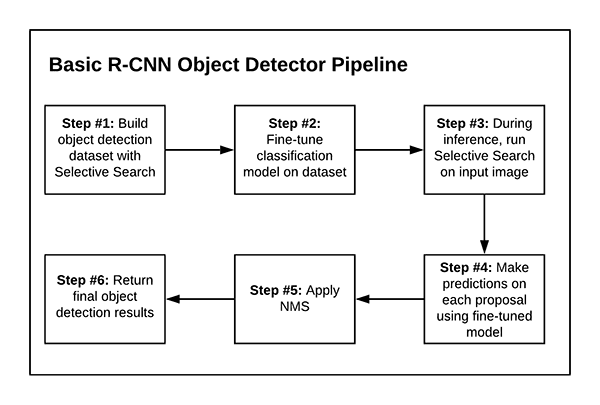

Da : https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/

Vedi : https://github.com/zarif101/rcnn_keras_license_plate


Partendo dal Raccoon dataset originale (nella dir data/raccons) verrà inizialmente creato un dataset (nella dir data/dataset) che verrà utilizzato per il fine tuning del modello CNN (MobileNet v2) al fine di ottenere il classificatore "finale" (raccoon_detector.h5)

In [1]:
# import the necessary packages
import os
import cv2


# define the base path to the *original* input dataset and then use
# the base path to derive the image and annotations directories
ORIG_BASE_PATH = "c:/dev/data/signDetector/test2"
ORIG_IMAGES = os.path.sep.join([ORIG_BASE_PATH, "images"])
ORIG_ANNOTS = os.path.sep.join([ORIG_BASE_PATH, "annotations"])

# define the base path to the *new* dataset after running our dataset
# builder scripts and then use the base path to derive the paths to
# our output class label directories
BASE_PATH = "c:/dev/data/signDetector/test2/dataset"
POSITVE_PATH = os.path.sep.join([BASE_PATH, "firme"])
NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_firme"])

# define the number of max proposals used when running selective
# search for (1) gathering training data and (2) performing inference
MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 2000

# define the maximum number of positive and negative images to be generated from each image
MAX_POSITIVE = 70
MAX_NEGATIVE = 50

# initialize the input dimensions to the network
INPUT_DIMS = (224, 224)

# define the path to the output model and label binarizer
#MODEL_PATH = "data/raccoon_detector.h5"
MODEL_PATH = "c:/dev/data/signDetector/test2/firme_detector"
ENCODER_PATH = "c:/dev/data/signDetector/test2/label_encoder.pickle"

# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.30

IOU rappresenta una metrica di misurazione della prediction dei bounding box.<br>
E' dato dal rapporto tra :
- area di overlap (intersection) tra bounding box predetto e ground-truth
- area della union tra bounding box predetto e ground-truth


In [2]:
def compute_iou(boxA, boxB):
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

Attenzione

In [3]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.5):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [57]:
def NMS(boxes, overlapThresh = 0.4):
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    #return only the bo
    return boxes[indices].astype(int)

In [4]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

Funzione di utility che viene utilizzata in fase di caricamento del dataset per il fine-tuning del modello.<br>
Riceve in input un path e restituisce i percorsi delle le immagini presenti (con estensione compresa nell'elenco)

In [5]:
import os

image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        
        # loop over the filenames in the current directory
        for filename in filenames:
            
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

Il primo step consiste nella creazione del dataset da utilizzare per il fine tuning del modello MobileNetV2 (pre-trained su Imagenet)

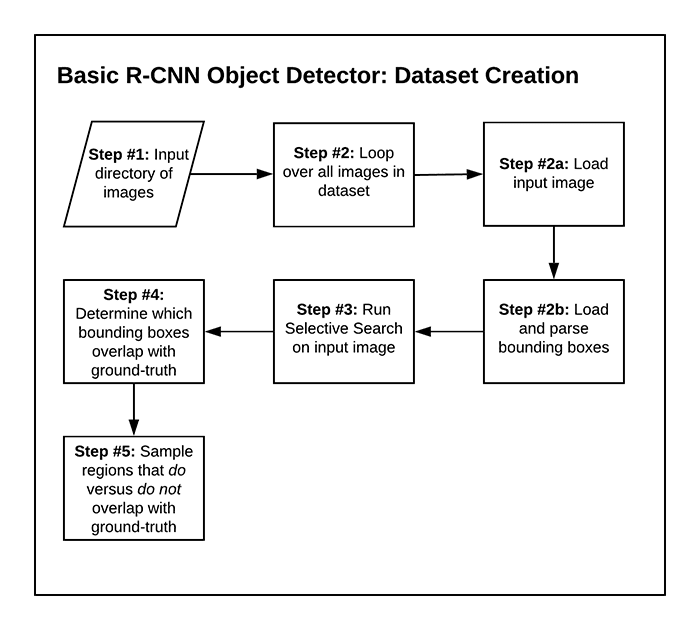

In [6]:
# import the necessary packages
from bs4 import BeautifulSoup


In [7]:
# loop over the output positive and negative directories
for dirPath in (POSITVE_PATH, NEGATIVE_PATH):
    # if the output directory does not exist yet, create it
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)
# grab all image paths in the input images directory

imagePaths = list(list_images(ORIG_IMAGES))

# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

Dopo aver creato le directory di destinazione del dataset che verrà creato, inizio ad elaborare le immagini di input.
Per ogni immagine presente in input:
- estraggo il nome del file
- accedo al corrispondente file XML di annotation(in formato PASCAL VOC) che contiene il bounding box annotato manualmente (ground truth)
- faccio il parsing del file XML per estrarre la label e le coordinate del box e le memorizzo
- carico l'immagine e eseguo l'algoritmo di selective search al fine di ottenere una serie di region proposal
- eseguo un loop tra i bounding box ottenuti da SS e per ogni region proposal calcolo IOU con il ground truth 
- vado a scrivere l'immagine compresa nel box nella directory di destinazione  
    - nella dir "POSITIVA" se l'immagine dei box con IOU > del 70%
    - nella dir "NEGATIVA" se l'immagine dei box con IOU < del 5%
  viene fatto il resize dell'immagine alle dimensioni previste dal CNN


In [8]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    
    # show a progress report
    print("[INFO] processing image {}/{}...".format(i + 1, len(imagePaths)))
    
    # extract the filename from the file path and use it to derive the path to the XML annotation file
    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([ORIG_ANNOTS, "{}.xml".format(filename)])
    
    # load the annotation file, build the soup, and initialize our list of ground-truth bounding boxes
    contents = open(annotPath).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = []
    
    # extract the image dimensions
    w = int(soup.find("width").string)
    h = int(soup.find("height").string)
    
    # loop over all 'object' elements
    for o in soup.find_all("object"):
        # extract the label and bounding box coordinates
        label = o.find("name").string
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)
        # truncate any bounding box coordinates that may fall outside the boundaries of the image
        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)
        
        # update our list of ground-truth bounding boxes
        gtBoxes.append((xMin, yMin, xMax, yMax))
        
    # load the input image from disk
    image = cv2.imread(imagePath)
    # run selective search on the image and initialize our list of
    # proposed boxes
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    print("Numero di rettangoli generati : " +str(len(rects)))
    
    proposedRects= []
    # loop over the rectangles generated by selective search
    for (x, y, w, h) in rects:
    # convert our bounding boxes from (x, y, w, h) to (startX, startY, endX, endY)
        proposedRects.append((x, y, x + w, y + h))
        
    # initialize counters used to count the number of positive and
    # negative ROIs saved thus far
    positiveROIs = 0
    negativeROIs = 0
    
    # Per ogni regione individuata nell'immagine verifico la IOU con i ground-truth boxes
    # loop over the maximum number of region proposals
    for proposedRect in proposedRects[:MAX_PROPOSALS]:
        
        # unpack the proposed rectangle bounding box
        (propStartX, propStartY, propEndX, propEndY) = proposedRect
        
        # loop over the ground-truth bounding boxes
        for gtBox in gtBoxes:
            
            # compute the intersection over union between the two boxes and unpack the ground-truth bounding box
            iou = compute_iou(gtBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
            
            # initialize the ROI and output path
            roi = None
            outputPath = None        
            
            # check to see if the IOU is greater than 70% *and* that we have not hit our positive count limit
            if iou > 0.8 and positiveROIs <= MAX_POSITIVE:
                
                # extract the ROI and then derive the output path to the positive instance
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalPositive)
                outputPath = os.path.sep.join([POSITVE_PATH, filename])
                # increment the positive counters
                positiveROIs += 1
                totalPositive += 1
            
            print("Numero positivi generati : " +str(totalPositive))
            # determine if the proposed bounding box falls *within* the ground-truth bounding box
            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY    
            
            # check to see if there is not full overlap *and* the IoU
            # is less than 5% *and* we have not hit our negative count limit
            if not fullOverlap and iou < 0.05 and negativeROIs <= MAX_NEGATIVE:
                
                # extract the ROI and then derive the output path to the negative instance
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalNegative)
                outputPath = os.path.sep.join([NEGATIVE_PATH,filename])
                # increment the negative counters
                negativeROIs += 1
                totalNegative += 1            
            print("Numero negativi generati : " +str(totalNegative))
            # check to see if both the ROI and output path are valid
            if roi is not None and outputPath is not None:
                # resize the ROI to the input dimensions of the CNN
                # that we'll be fine-tuning, then write the ROI to disk
                roi = cv2.resize(roi, INPUT_DIMS,interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

[INFO] processing image 1/340...
Numero di rettangoli generati : 2041
[INFO] processing image 2/340...
Numero di rettangoli generati : 460
[INFO] processing image 3/340...
Numero di rettangoli generati : 1840
[INFO] processing image 4/340...
Numero di rettangoli generati : 358
[INFO] processing image 5/340...
Numero di rettangoli generati : 2039
[INFO] processing image 6/340...
Numero di rettangoli generati : 605
[INFO] processing image 7/340...
Numero di rettangoli generati : 2158
[INFO] processing image 8/340...
Numero di rettangoli generati : 1929
[INFO] processing image 9/340...
Numero di rettangoli generati : 485
[INFO] processing image 10/340...
Numero di rettangoli generati : 2598
[INFO] processing image 11/340...
Numero di rettangoli generati : 2362
[INFO] processing image 12/340...
Numero di rettangoli generati : 2214
[INFO] processing image 13/340...
Numero di rettangoli generati : 1883
[INFO] processing image 14/340...
Numero di rettangoli generati : 1826
[INFO] processing i

[INFO] processing image 117/340...
Numero di rettangoli generati : 1595
[INFO] processing image 118/340...
Numero di rettangoli generati : 3023
[INFO] processing image 119/340...
Numero di rettangoli generati : 1791
[INFO] processing image 120/340...
Numero di rettangoli generati : 3346
[INFO] processing image 121/340...
Numero di rettangoli generati : 2638
[INFO] processing image 122/340...
Numero di rettangoli generati : 1370
[INFO] processing image 123/340...
Numero di rettangoli generati : 2214
[INFO] processing image 124/340...
Numero di rettangoli generati : 2981
[INFO] processing image 125/340...
Numero di rettangoli generati : 2535
[INFO] processing image 126/340...
Numero di rettangoli generati : 1741
[INFO] processing image 127/340...
Numero di rettangoli generati : 1223
[INFO] processing image 128/340...
Numero di rettangoli generati : 2697
[INFO] processing image 129/340...
Numero di rettangoli generati : 2094
[INFO] processing image 130/340...
Numero di rettangoli generati

Numero di rettangoli generati : 1579
[INFO] processing image 232/340...
Numero di rettangoli generati : 1786
[INFO] processing image 233/340...
Numero di rettangoli generati : 1516
[INFO] processing image 234/340...
Numero di rettangoli generati : 1924
[INFO] processing image 235/340...
Numero di rettangoli generati : 523
[INFO] processing image 236/340...
Numero di rettangoli generati : 1127
[INFO] processing image 237/340...
Numero di rettangoli generati : 1224
[INFO] processing image 238/340...
Numero di rettangoli generati : 1510
[INFO] processing image 239/340...
Numero di rettangoli generati : 1761
[INFO] processing image 240/340...
Numero di rettangoli generati : 1007
[INFO] processing image 241/340...
Numero di rettangoli generati : 1973
[INFO] processing image 242/340...
Numero di rettangoli generati : 2037
[INFO] processing image 243/340...
Numero di rettangoli generati : 1388
[INFO] processing image 244/340...
Numero di rettangoli generati : 596
[INFO] processing image 245/3

Dopo aver creato il dataset è possibile iniziare il fine tuning del CNN al fine di riconoscere queste 2 classi ("RACCOON" e "NO RACCOON").<br>
Una volta terminata questa fase sarà possibile combinare SelectiveSearch + classificatore per avere R-CNN Object detector.<br>
Attraverso il fine-tuning, il modello di MobileNet V2 già pre-trained su Imagenet dataset, sarà in grado di predirre le 2 classi di nostro interesse ("RACCOON" e "NO RACCOON").

In [9]:
#from pyimagesearch import config
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import pickle
import os

Definizione di una serie di iperparametri 

In [10]:
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())
# initialize the initial learning rate, number of epochs to train for,
PLOT="data/plot.png"
# and batch size
INIT_LR = 1e-4   # learning rate
EPOCHS = 5  # numero di epoch
BS = 32     # batch size

Le immagini vengono caricate dal dataset precedentemente creato utilizzando la funzione di utility list_images().
Vengono creati 2 liste:
- lista delle immagini
- lista delle rispettive labels

In [11]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(list_images(BASE_PATH))

data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
#    print(imagePath)
    
    # extract the class label from the filename (corrisponde a una delle 2 dir "RACCON" e "NO_RACCOON")
    label = imagePath.split(os.path.sep)[-2]
    
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=INPUT_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
print("[INFO] Images loaded...")    

[INFO] loading images...
[INFO] Images loaded...


In [12]:
print("Immagini " +str(len(data)))
print("Labels " +str(len(labels)))

Immagini 18298
Labels 18298


Dopo aver convertito le 2 liste in numpy arrays, faccio one-hot encode delle labels

In [13]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

print(data.shape)
print(labels.shape)
labels

(18298, 224, 224, 3)
(18298, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Suddivisione dei dati di input (immagini + labels) nei dataset di train e test e inizializzazione del ImageDataGenerator x data augmentation

In [14]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

Scarico il modello di CNN pre-trained su imagenet senza i FC originali che fanno da classificatore e vado a creare un nuovo FC layer che classifichi le 2 classi di interesse.
Il nuovo FC viene quindi posto in testa al CNN e vengono resi non trainable i weights originati del CNN

In [15]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Procedo quindi con la compilazione del nuovo modello e con il fine tuning dello stesso. Come input viene utilizzato il training dataset con Augmentation

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
#    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
#    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
458/458 [==============================] - 448s 973ms/step - loss: 0.1056 - accuracy: 0.9652 - val_loss: 0.0456 - val_accuracy: 0.9833
Epoch 2/5
458/458 [==============================] - 427s 933ms/step - loss: 0.0503 - accuracy: 0.9808 - val_loss: 0.0408 - val_accuracy: 0.9839
Epoch 3/5
458/458 [==============================] - 439s 959ms/step - loss: 0.0420 - accuracy: 0.9849 - val_loss: 0.0388 - val_accuracy: 0.9839
Epoch 4/5
458/458 [==============================] - 436s 953ms/step - loss: 0.0372 - accuracy: 0.9859 - val_loss: 0.0381 - val_accuracy: 0.9850
Epoch 5/5
458/458 [==============================] - 421s 919ms/step - loss: 0.0370 - accuracy: 0.9856 - val_loss: 0.0378 - val_accuracy: 0.9861


In [17]:
len(testY)

3660

Dopo aver concluso il fine tuning del modello, è possibile procedere alla valutazione del modello stesso utilizzando il test set

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       firme       0.85      0.94      0.89       228
    no_firme       1.00      0.99      0.99      3432

    accuracy                           0.99      3660
   macro avg       0.92      0.97      0.94      3660
weighted avg       0.99      0.99      0.99      3660



Procediamo all'export del modello di classificatore e del label encoder

In [19]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...


C:\Users\axc0462\Anaconda3\envs\tf-env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


[INFO] saving label encoder...


Per concludere viene predisposto il grafico di accuracy e loss durante il training

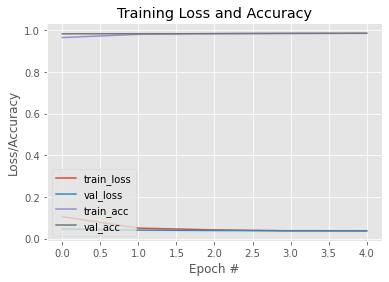

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(PLOT)

### INFERENCE

Dopo aver concluso il fine tuning del classificatore, è possibile procedere ad assemblare l'object detector da utilizzare in fase di inference

In [82]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import cv2
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,help="path to input image")

# Immagine da utilizzare per infernce
#IMAGE = "data/images/raccoon-123.jpg"
#IMAGE = "C:\dev\DATA\signDetector\images/file_7434258.pdf_1.jpg"
#IMAGE = "c:/dev/data/signDetector/test2/images/file_7435143.pdf_3.jpg"
IMAGE = "c:/dev/data/signDetector/test2/images/file_6896808.pdf_9.jpg"


- Carica il modello di classificatore e il label encoder.
- Carica l'immagine di test
- Esegue l'algoritmo di selective search sull'immagine al fine di ricavare una serie di region proposals

In [83]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(ENCODER_PATH, "rb").read())

# load the input image from disk
image = cv2.imread(IMAGE)
image = resize(image, width=500)

# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print("[INFO] {} total region proposals".format(len(rects)))

[INFO] loading model and label binarizer...
[INFO] running selective search...
[INFO] 1865 total region proposals


Dopo aver inizializzato le liste che dovranno conterere le immagini delle ROI e le corrispondenti coordinate dei bounding box, per ognuna delle regioni proposte dalla selectiveSearch:

- estraggo la regione dall'immagine originale (con numpy slicing), 
- la converto da BRG a RGB 
- faccio il resize alla dimensione prevista dal modello
- faccio preprocess standard
- aggiungo il roi alla lista
- aggiungo le coordinate alla lista

La lista boxes contiene le coordinate riferite all'immagine originale

In [84]:
# initialize the list of region proposals that we'll be classifying along with their associated bounding boxes
proposals = []
boxes = []

# loop over the region proposal bounding box coordinates generated by running selective search
for (x, y, w, h) in rects[:MAX_PROPOSALS_INFER]:
    
    # extract the region from the input image, convert it from BGR to RGB channel ordering,
    # and then resize it to the required input dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, INPUT_DIMS,interpolation=cv2.INTER_CUBIC)
    
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))
    
print("Regioni : " +str(len(proposals)))

Regioni : 1865


Procedo con la cliassificazione delle regioni proposte (dopo aver convertito le liste in numpy array).<br>
Con il metodo predict sulle regioni proposte, ottengo le corrispondenti predictions

In [85]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)
print("[INFO] proposal shape: {}".format(proba.shape))

[INFO] proposal shape: (1865, 224, 224, 3)
[INFO] classifying proposals...
[INFO] proposal shape: (1865, 2)


In [86]:
print(proba)
print(np.argmax(proba))

lb.classes_

[[3.9123971e-09 1.0000000e+00]
 [2.5627679e-11 1.0000000e+00]
 [4.4735341e-04 9.9955267e-01]
 ...
 [2.1555362e-04 9.9978441e-01]
 [1.4362917e-03 9.9856371e-01]
 [2.0124051e-03 9.9798763e-01]]
1


array(['firme', 'no_firme'], dtype='<U8')

A questo punto è necessario filtrare i risultati positivi ("RACCOON").
Ottengo quindi 2 liste:
- boxes : con le coordinate dei roi contenenti RACCONS
- proba : con le corrispondenti probabilità 

In [87]:

labels = lb.classes_[np.argmax(proba, axis=1)]
print(labels)
# Estraggo gli indici delle prediction con esito positivo (= raccoon)
idxs = np.where(labels == "firme")[0]
print(idxs)

# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "raccoon" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]
print(proba)
# further filter indexes by enforcing a minimum prediction probability be met
idxs = np.where(proba >= MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]
print("[INFO] {} totale box positivi".format(len(boxes)))
print("[INFO] {} totale proba positivi".format(len(proba)))

['no_firme' 'no_firme' 'no_firme' ... 'no_firme' 'no_firme' 'no_firme']
[  21   23   32   40   51   72  114  159  170  178  180  203  241  268
  278  310  329  340  342  367  405  409  438  447  450  464  470  479
  485  493  494  497  500  505  508  514  526  529  545  547  594  608
  621  624  632  669  670  678  686  695  699  716  718  722  724  727
  777  788  805  810  827  832  838  858  867  872  889  898  901  905
  910  912  927  930  957  959  964  967  982  986  989  990  997  998
 1001 1004 1007 1032 1036 1051 1066 1072 1092 1093 1110 1111 1116 1130
 1132 1139 1145 1153 1166 1169 1171 1172 1188 1202 1206 1210 1214 1215
 1219 1225 1231 1240 1243 1245 1247 1248 1264 1269 1270 1281 1309 1311
 1312 1313 1317 1320 1327 1328 1338 1344 1346 1363 1366 1371 1372 1373
 1374 1380 1386 1388 1390 1402 1403 1404 1407 1411 1413 1414 1417 1418
 1422 1424 1425 1428 1431 1434 1439 1442 1443 1446 1455 1456 1458 1460
 1468 1469 1471 1473 1476 1479 1486 1488 1504 1507 1508 1509 1516 1517
 1522

Partendo dall'immagine originale, visualizzo i risultati ottenuti prima di applicare NMS.
Per ogni box e corrispondente probabilità:
- estraggo le coordinate
- disegno il corrispondente rettangolo sull'immagine originale (clonata) e la relativa probabilità
- visualizzo l'immagine a video

In [88]:
# clone the original image so that we can draw on it
clone = image.copy()

# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Firma: {:.2f}%".format(prob * 100)
    cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after *before* running NMS
cv2.imshow("Before NMS", clone)
cv2.waitKey(0)

-1

Applico l'algoritmo di NMS (Non Max Suppression) al fine di eliminare tutti i bounding box sovrapposti.<br>
Visualizzo sull'immagine originale i bounding box rimasti e le relative probabilità

In [110]:
import tensorflow as tf

finale = image.copy()

# find the index of all predictions that are positive for the "raccoon" class
print("[INFO] applying NMS...")
#boxIdxs = non_max_suppression(boxes, proba, overlapThresh=0.5)
#boxIdxs = NMS(boxes, overlapThresh=0.9)
boxIdxs = tf.image.non_max_suppression(boxes, proba,max_output_size=7, iou_threshold=0.5)
print(boxIdxs)
# loop over the bounding box indexes
for i in range(len(boxIdxs)):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = boxes[i]
    cv2.rectangle(finale, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Firma: {:.2f}%".format(proba[i] * 100)
    cv2.putText(finale, text, (startX, y),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2.imshow("After NMS", finale)
cv2.waitKey(0)

[INFO] applying NMS...
tf.Tensor([14 25 15  8 18  5  1], shape=(7,), dtype=int32)


-1

In [51]:
def plt_imshow(title, image):
    
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

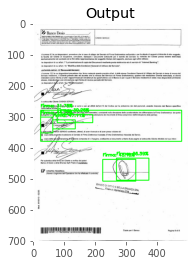

In [52]:
plt_imshow("Output", image)